In [95]:
# ONLY RUN THIS CELL IF YOU WANT TO DELETE ALL OF THE FILES STORED IN THIS NOTEBOOK
# Used for development purposes so I can add new downloads, update files from github, etc

# Sourced from https://stackoverflow.com/questions/13118029/deleting-folders-in-python-recursively and slightly adapted
from pathlib import Path

def rmdir(directory):
    directory = Path(directory)
    for item in directory.iterdir():
        if item.is_dir() and directory != '.':
            rmdir(item)
        else:
            item.unlink()

rmdir(Path("."))

In [96]:
!wget https://github.com/portoaj/CSE151A-Project/raw/main/AnnotatedData.zip
!wget https://github.com/portoaj/CSE151A-Project/raw/main/Examples/dataannotationexample.png

!unzip AnnotatedData.zip -d AnnotatedData

--2024-02-12 03:20:00--  https://github.com/portoaj/CSE151A-Project/raw/main/AnnotatedData.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/portoaj/CSE151A-Project/main/AnnotatedData.zip [following]
--2024-02-12 03:20:00--  https://raw.githubusercontent.com/portoaj/CSE151A-Project/main/AnnotatedData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2863460 (2.7M) [application/zip]
Saving to: ‘AnnotatedData.zip’

AnnotatedData.zip   100%[===================>]   2.73M  --.-KB/s    in 0.07s   

2024-02-12 03:20:00 (37.6 MB/s) - ‘AnnotatedData.zip’ saved [2863460/2863460]

--2024-02-12 03:20:00

# Labeled Data

In [97]:
# Lets load the annotations file
import json

with open('/content/AnnotatedData/_annotations.coco.json') as annotations_file:
  annotations_object = json.load(annotations_file)

# The different categories of information stored in the annotations file
print(annotations_object.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [98]:
# Lets get the annotation and image data from the json
annotations = annotations_object['annotations']
images = annotations_object['images']

num_annotations = len(annotations)
num_images = len(images)

AUGMENTATION_FACTOR = 3 # 3x the original images were created for the eventual dataset using dataset augmentation

# Let's see what data is held about each image
print('Details held for each image: ', list(images[0].keys()))
print('Example of the data held for the first image: ', images[0])
print(f'There are {num_images} images held in the dataset including the data augmentations, and {int(num_images/ AUGMENTATION_FACTOR)} without')

Details held for each image:  ['id', 'license', 'file_name', 'height', 'width', 'date_captured']
Example of the data held for the first image:  {'id': 0, 'license': 1, 'file_name': '41_png.rf.27a34583fefe1d77e7a873b0e3109c5b.jpg', 'height': 640, 'width': 640, 'date_captured': '2024-02-12T01:30:37+00:00'}
There are 108 images held in the dataset including the data augmentations, and 36 without


In [99]:
# Lets delve into the annotations
print('Details held for each annotation: ', list(annotations[0].keys()))
print('Example of the data held for the first annotation: ', annotations[0])
print(f'There are {num_annotations} annotations held in the dataset including the data augmentations, and {int(num_annotations/ AUGMENTATION_FACTOR)} without')

Details held for each annotation:  ['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd']
Example of the data held for the first annotation:  {'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [196, 306, 15.297, 17.262], 'area': 264.05, 'segmentation': [], 'iscrowd': 0}
There are 5139 annotations held in the dataset including the data augmentations, and 1713 without


         ImageId  NumAnnotations
count  108.00000      108.000000
mean    53.50000       47.583333
std     31.32092       39.195681
min      0.00000        4.000000
25%     26.75000       15.000000
50%     53.50000       30.500000
75%     80.25000       80.250000
max    107.00000      166.000000


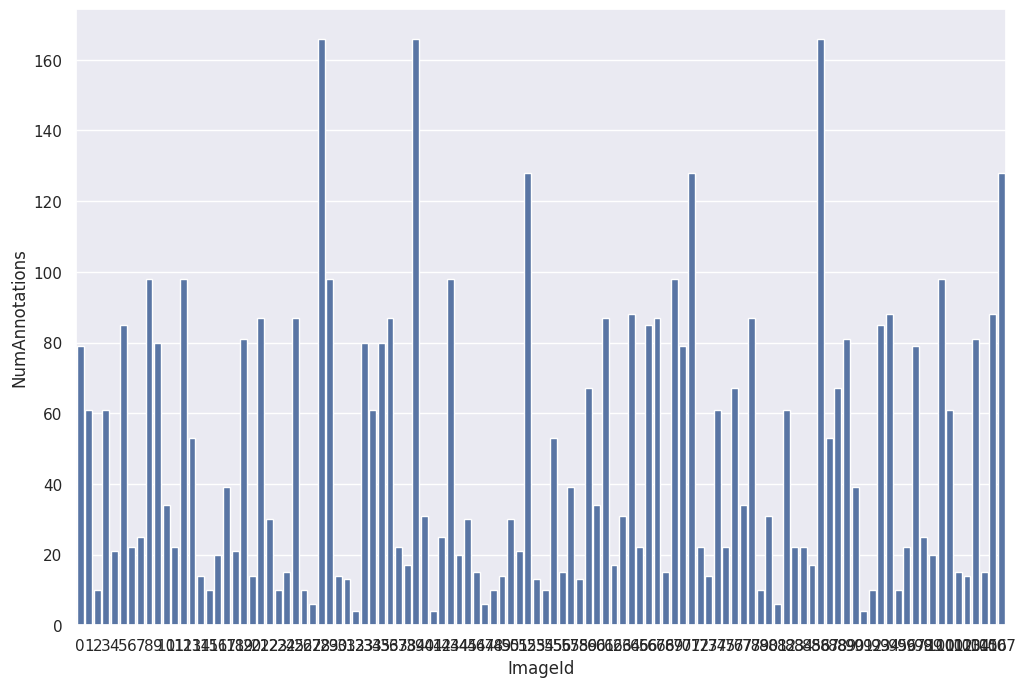

In [100]:
# Lets plot how many annotations each image has
import pandas as pd
import seaborn as sns

# Generate a list with the number of annotations for each image
annotations_numbers = list()
for i in range(num_images):

  num_annotations = 0
  for annotation in annotations:
    if annotation['image_id'] == i:
      num_annotations += 1
  annotations_numbers.append([i, num_annotations])
annotations_num_df = pd.DataFrame(annotations_numbers, columns=['ImageId', 'NumAnnotations'])

sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(annotations_num_df, x='ImageId', y='NumAnnotations')

# Describe different characteristics of the number of annotations
print(annotations_num_df.describe())

# One thing that stands out to me from this is how high the std deviation of the number of annotations is at 39.
# This is also seen from the bar graph, in which some keyboards have as many as 160 annotations and others have as low as 4.

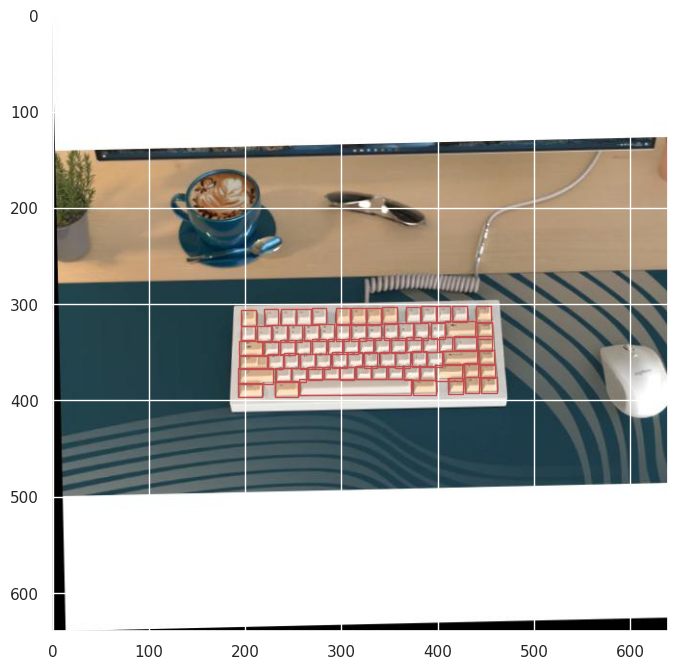

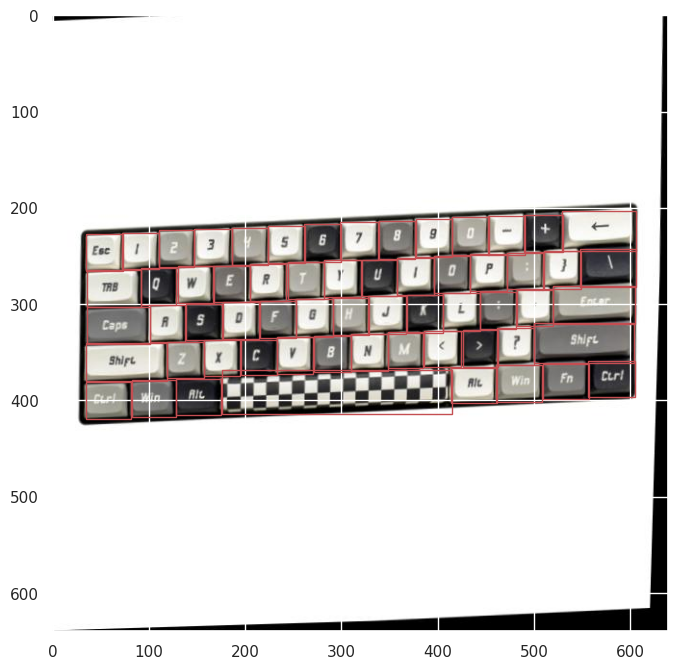

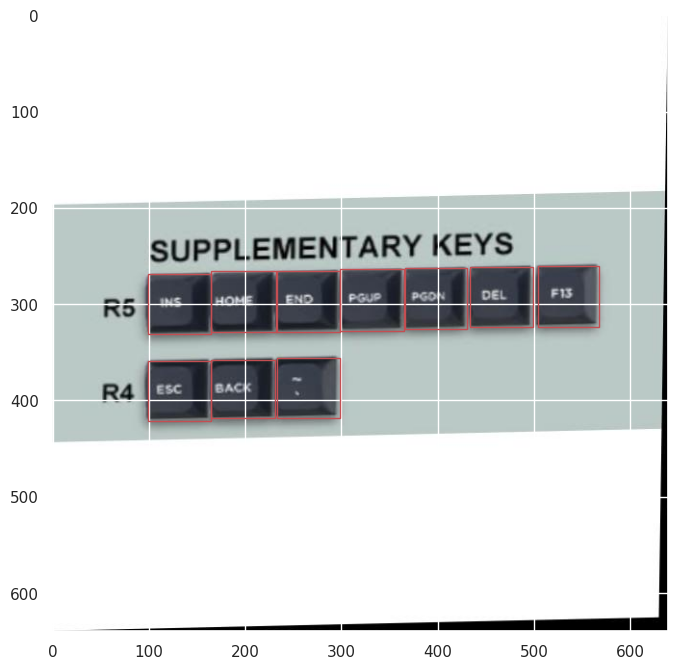

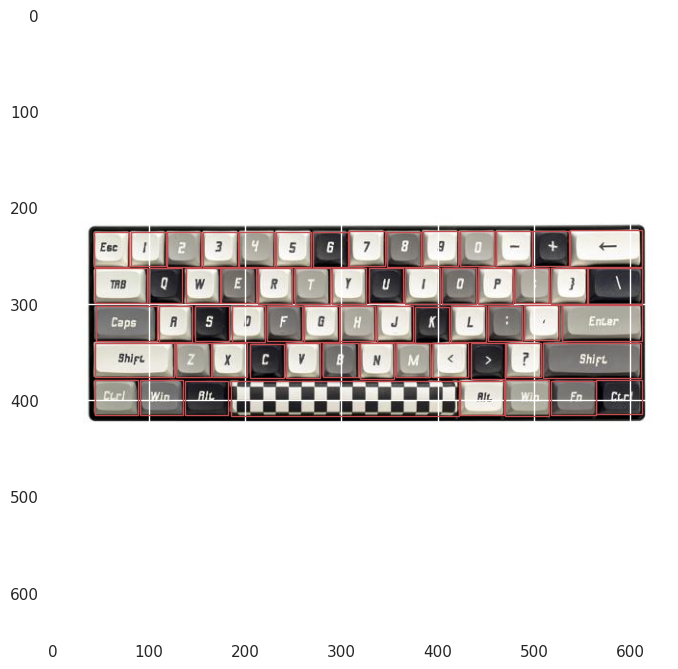

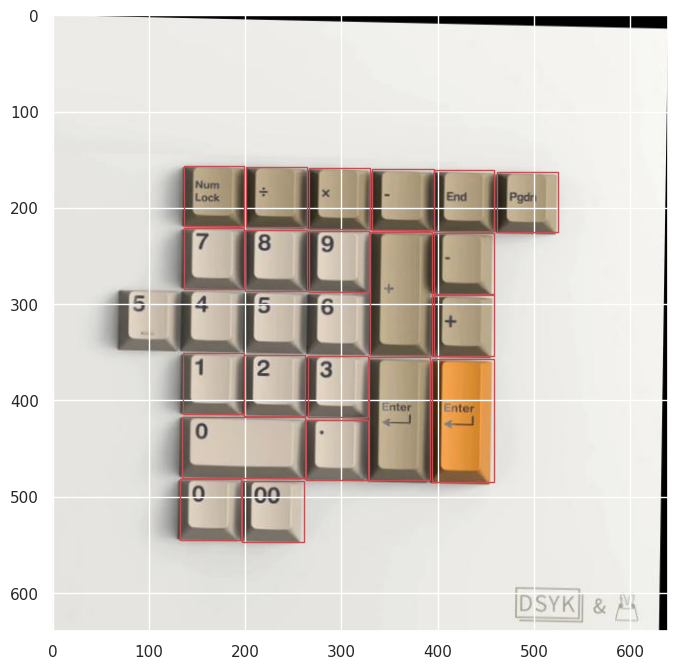

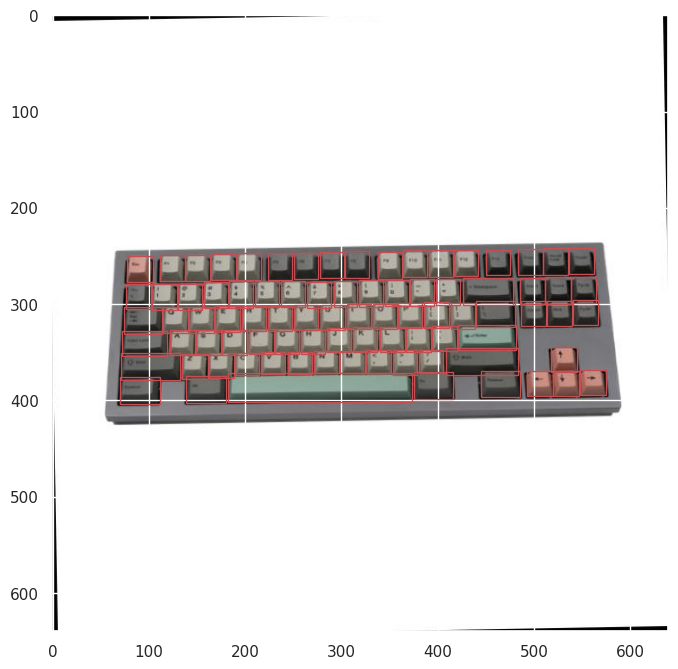

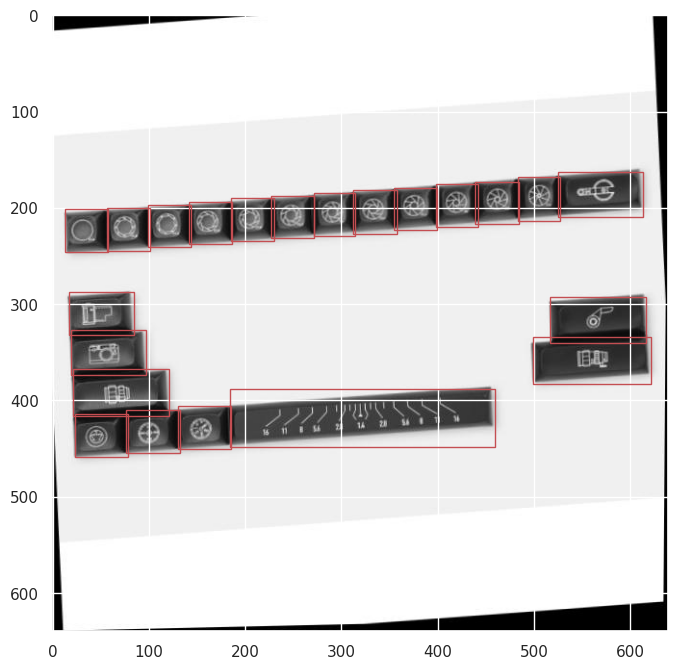

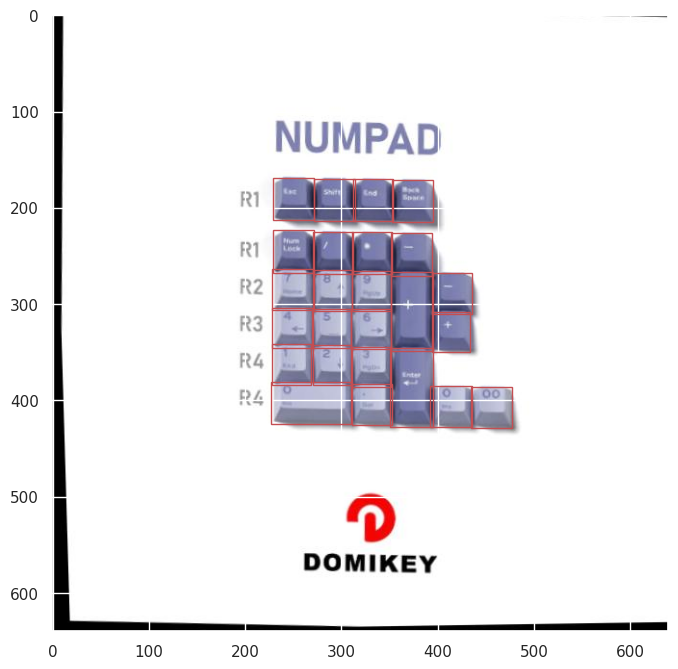

In [106]:
# Now lets create a helper to show the annotations of an image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import os

def show_annotated_image(image_id, edgecolor='r'):
  im = Image.open(f'AnnotatedData/{images[image_id]["file_name"]}' )
  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  for annotation in annotations:
    if annotation['image_id'] == image_id:
      # Create a Rectangle patch
      width, height = im.size
      data = annotation['bbox']
      x = float(data[0])
      y = float(data[1])
      width = float(data[2])
      height = float(data[3])
      #print(x,y,width,height)
      rect = patches.Rectangle((x,y),width,height, linewidth=1, edgecolor=edgecolor, facecolor='none')
      ax.add_patch(rect)

  # Add the patch to the Axes


  plt.show()

# Here we display the first 8 images with their annotations

for i in range(8):
  show_annotated_image(i)

# Now it makes sense why there's such a disparity in the number of annotations in the images,
# some are entire keyboards while some only include some supplementary keys or a number pad

# Unlabeled Data


In [102]:
import requests
import tqdm as tqdm
# We can find all the different product collections at kbdfans.com/collections.json
collections = requests.get('https://kbdfans.com/collections.json?limit=250').json()['collections']
print([collection['handle'] for collection in collections])

# Heres the data for their different keycap sets
keycap_sets = requests.get('https://kbdfans.com/collections/keycaps/products.json?limit=250&page=0').json()['products']
print([product['title'] for product in keycap_sets])

if not os.path.exists('UnlabeledData'):
  os.mkdir('UnlabeledData')

# Image downloading code from https://stackoverflow.com/questions/30229231/python-save-image-from-url
for i, keycap_set in tqdm.tqdm(list(enumerate(keycap_sets))):
  image_url = keycap_set['images'][0]['src']
  img_data = requests.get(image_url).content
  with open(f'UnlabeledData/{i}.jpg', 'wb') as handler:
      handler.write(img_data)


['100-assembled-keyboard', '100-diy-kit', '100-keyboard', '20-fully-assembled', '20-diy-kit', '20-keyboard', '20-keyboard-category', '20-layout-case', '20', '2024-cny', '40', '40-fully-assembled', '40-diy-kit', '40-keyboard-category', '40-layout-case', '50', '50-diy-kit', '50-layout-plate', '60', '60-fully-assembled', '60-diy-kit', '60-keyboard', '60-keyboard-category', '60-layout-case', '60-layout-plate-1', '65', '65-fully-assembled', '65-diy-kit', '65-keyboard', '65-keyboard-category', '65-layout-case', '65-layout-plate', '75', '75-fully-assembled', '75-diy-kit', '75-keyboard', '75-keyboard-category', '75-layout-case', '75-layout-plate', '90-kbd19x', '80-fully-assembled', '80-diy-kit', '80-keyboard', '80-keyboard-category', '80-layout-plate', '90-diy-kit-1', '95-kbd19x', '95-fully-assembled', '95-diy-kit', '95-keyboard', '95-keyboard-category', 'keyboard-part', 'akuma', 'artisan-keycap', 'artisan-keycaps', 'artkey', 'assembly-service', 'b-stock', 'b-stock-40', 'b-stock-60', 'b-stock-

100%|██████████| 179/179 [01:15<00:00,  2.38it/s]
